# Age masks for daily climatology

Creating a water mass mask, for the daily data. 

This notebook is done to develop the code. The actual final calcualtion is done through monthly submissions to the queue.

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram
from tqdm import tqdm
import pandas as pd

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(n_workers=28, memory_limit='250gb')

Let's import dthe daily interpolated age

In [3]:
age_interpolated = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_interpolated_daily/OM2_01_iaf_cycle3/age_interpolated_*.nc')


In [4]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ylength=580

Importing density for rebinning

In [5]:
#We will also need to interpoalte the density daily
σ_3d_monthly= cc.querying.getvar(iaf_cycle3,'pot_rho_0', session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))

#age from the end of iaf  yle 2, to appemnd to the cycle 3
σ_IC= cc.querying.getvar('01deg_jra55v140_iaf_cycle2','pot_rho_0' , session,n=-1,chunks={})\
.isel(yt_ocean=slice(0,ylength)).isel(time=-1,drop=True)

#age for the beggining of cycle 4 to append to data
σ_ICf= cc.querying.getvar('01deg_jra55v140_iaf_cycle4','pot_rho_0' , session,n=0,chunks={})\
.isel(yt_ocean=slice(0,ylength)).isel(time=0,drop=True)




#calculating the time edges for interpolation
time_edge0_age = σ_3d_monthly.time.isel(time=0) - σ_3d_monthly.time.isel(time=slice(0,2)).diff('time')  #initial time for appending the halo
time_edgef_age = σ_3d_monthly.time.isel(time=-1) +σ_3d_monthly.time.isel(time=slice(0,2)).diff('time') #final time for appending the halo

#correcting the time edges for creating of the new cocated data
σ_IC = σ_IC.expand_dims(time = time_edge0_age)
σ_ICf = σ_ICf.expand_dims(time = time_edgef_age)


# #creating the age var with the halo
σ_3d_monthly = xr.concat((σ_IC,σ_3d_monthly,σ_ICf),dim = 'time')
print('time-halo created around densities')

time-halo created around densities


In [6]:
#we do not have daily σ, but we do have temperature and saolinity. So let's use that to calcualted daily densities
T_3d_daily= cc.querying.getvar(iaf_cycle3,'temp', session,frequency='1 daily',chunks={}).isel(yt_ocean=slice(0,ylength)) - 273.15
S_3d_daily= cc.querying.getvar(iaf_cycle3,'salt', session,frequency='1 daily',chunks={}).isel(yt_ocean=slice(0,ylength))


Converting practical to absolute salinity for posterior density calculation

In [7]:
from gsw import sigma0, SA_from_SP, p_from_z

In [8]:
#part 1, calcualting pressure 
lat_3d_daily = ((S_3d_daily*0)+1) * S_3d_daily.yt_ocean
z_3d_daily = -((S_3d_daily*0)+1) * S_3d_daily.st_ocean
p_3d_daily = p_from_z(z_3d_daily,lat_3d_daily)
#part 2, calcualting absolute salinity
lon_3d_daily = ((S_3d_daily*0)+1) * S_3d_daily.xt_ocean
AS_3d_daily = SA_from_SP(S_3d_daily, p_3d_daily, lon_3d_daily, lat_3d_daily)

Loop to:

- [a] Calculate the daily densitites within a specification month
- [b] create daily mask in monthly chunks and save it

In [9]:
#first, creating the Z mask so we make sure we get the right sigmas in the right locations
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

#unbinned mask
unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour.isel(time=0)
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)
unbinned_depth_mask.load()

<xarray.DataArray 'unbinned_heat_transp_across_contour' (st_ocean: 75,
                                                         contour_index: 6002)> Size: 2MB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * st_ocean       (st_ocean) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
    time           datetime64[ns] 8B 1958-01-01T12:00:00
    TLON           (contour_index) float32 24kB 80.05 80.15 ... 79.95 79.95
    TLAT           (contour_index) float32 24kB -66.03 -66.03 ... -66.07 -66.03
    ULON           (contour_index) float32 24kB -279.9 -279.8 ... 80.0 80.0
    ULAT           (contour_index) float32 24kB -66.01 -66.01 ... -66.05 -66.01

In [10]:
#lighter CSHT matrix to make easier to find TS along isobath
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_along = CSHT_along.isel(time=0).drop('time')

In [11]:
#importing dzt monthly. This will have to be interpoalted in time
dzt_3d_monthly= cc.querying.getvar(iaf_cycle3,'dzt', session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))



#age from the end of iaf  yle 2, to appemnd to the cycle 3
dzt_IC= cc.querying.getvar('01deg_jra55v140_iaf_cycle2','dzt' , session,n=-1,chunks={})\
.isel(yt_ocean=slice(0,ylength)).isel(time=-1,drop=True)

#age for the beggining of cycle 4 to append to data
dzt_ICf= cc.querying.getvar('01deg_jra55v140_iaf_cycle4','dzt' , session,n=0,chunks={})\
.isel(yt_ocean=slice(0,ylength)).isel(time=0,drop=True)


#correcting the time edges for creating of the new cocated data
dzt_IC = dzt_IC.expand_dims(time = time_edge0_age)
dzt_ICf = dzt_ICf.expand_dims(time = time_edgef_age)


# #creating the age var with the halo
dzt_3d_monthly = xr.concat((dzt_IC,dzt_3d_monthly,dzt_ICf),dim = 'time')
print('time-halo created around zt')

time-halo created around zt


Importing area along isobath to calcualte the volume for histogram weighting

In [12]:
#area
area = cc.querying.getvar(iaf_cycle3,'area_t' , session,n=1).isel(yt_ocean=slice(0,ylength))
area_transect = area.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask
area_transect = area_transect.drop('time')
area_transect.load()
print('Loaded area along the isobath')


Loaded area along the isobath


Getting target bins

In [13]:
rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)-1000

creating $3^o$ binnng function, so the later loop for age is shorter

In [14]:
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*')

In [15]:
def binning_age_3deg(CSHT_along, age_sigma, vol_sigma, CSHT_for_3degbinning):
    
    #binning into 3deg
    bin_width = 3
    bin_spacing = 0.25
    lon_west = -280
    lon_east = 80
    
    # new coordinate and midpoints of longitude bins:
    full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
    lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
    
    n_bin_edges = len(full_lon_coord)
    lon_along_contour = np.array(CSHT_along.lon_along_contour)
    lat_along_contour = np.array(CSHT_along.lat_along_contour)
    
    
    bin_edge_indices = np.zeros(n_bin_edges)
    for lon_bin in range(n_bin_edges-1):
        # find first isobath point that has the right longitude:
        first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
        # then find all other isobath points with the same longitude as that first point:
        same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
        # we want the most southerly of these points on the same longitude line:
        bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
        
    # define east/west edges:
    bin_edge_indices = bin_edge_indices.astype(int)
    bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
    bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
    n_bins = len(bin_edge_indices_west)
    
    
    lat_bin_midpoints = np.zeros(n_bins)
    for lon_bin in range(n_bins):
        # find nearest isobath point:
        lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
        lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
    
    #averaging the age along the contour, in sigma bins
    age_sigma = age_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    
    age_contour_3deg = np.zeros([age_sigma.shape[0],108,n_bins])*np.nan
    for lon_bin in range(n_bins):
        age_contour_3deg0 = age_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        #making sure we only have distances where there are values
        distance_along0 = ((age_contour_3deg0 *0)+1) *distance_along0
        age_contour_3deg[:,:,lon_bin] = (np.nansum(age_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))
    
    #removing zeros
    age_contour_3degnp = np.where(age_contour_3deg!=0,age_contour_3deg,np.nan)
    
    
    #ages
    age_contour_3deg = CSHT_for_3degbinning.binned_cross_slope_heat_trans.copy()
    age_contour_3deg.name = 'age'
    age_contour_3deg.values = age_contour_3degnp
    
    vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    
    vol_contour_3deg = np.zeros([age_sigma.shape[0],108,n_bins])*np.nan
    for lon_bin in range(n_bins):
        vol_contour_3deg0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        vol_contour_3deg[:,:,lon_bin] = (np.nansum(vol_contour_3deg0,axis=2))
    
    #removing zeros
    vol_contour_3degnp = np.where(vol_contour_3deg!=0,vol_contour_3deg,np.nan)
    
    #volumes_rho
    vol_contour_3deg = CSHT_for_3degbinning.binned_cross_slope_heat_trans.copy()
    vol_contour_3deg.name = 'Volume'
    vol_contour_3deg.values = vol_contour_3degnp
    
    
    return age_contour_3deg, vol_contour_3deg

Finally, running the looped operations and creating tehe age masks

In [25]:
%%time
#doing the whole procedule monthly.
savedir_ages = '/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/'
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins
newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
for n in tqdm(range(2,2)):
    #print(str(n) + '-' + str((n+1) +1) + '\n \n')
    σ_n = σ_3d_monthly.isel(time=slice(n,(n+3))) #getting a month before and after the year start, so the interpolation accounts for the edges
    dzt_n = dzt_3d_monthly.isel(time=slice(n,(n+3))) #getting a month before and after the year start, so the interpolation accounts for the edges
    start_monthly_age = σ_n.time.isel(time=0) #real start monthly age to use for interpolation
    end_monthly_age = σ_n.time.isel(time=-1) #real end monthly age to use for interpolation
    # #the target year is
    target_year = str(σ_n.time.dt.year[1].values)
    target_month = str(σ_n.time.dt.month[1].values)
    target_start_time=target_year + '-' + target_month.zfill(2) + '-01'
    # #creating the matrix of daily times for interpolation
    target_daily_time = T_3d_daily.time.sel(time = target_year + '-' + target_month.zfill(2) )
    #calculating daily σ0
    T_n = T_3d_daily.sel(time = target_year + '-' + target_month.zfill(2) )
    S_n = AS_3d_daily.sel(time = target_year + '-' + target_month.zfill(2) )
    age_daily = age_interpolated.sel(time = target_year + '-' + target_month.zfill(2) )
    #extracting values along the isobath
    T_n = T_n.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask
    S_n = S_n.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask
    age_daily = age_daily.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask
    CSHT_for_3degbinning = CSHT_along_fine.sel(time = target_year + '-' + target_month.zfill(2) )
    #loading TS for faster sigma0 calculation
    T_n.load()
    S_n.load()
    age_daily.load()
    #calculating sigma0
    σ_daily = sigma0(S_n, T_n)
    #Converting DZT to daily, and extracting values along isobath after (conversion before to assure itnerpolaation takes into account all dimensions)
    dzt_daily = dzt_n.interp(time = target_daily_time)
    dzt_daily = dzt_daily.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest') * unbinned_depth_mask
    dzt_daily.load()
    #calculating the volume of each cell
    vol_transect = area_transect * dzt_daily
    # lets now bin the age in sigma coords through the Histogram method
    σ_daily.name = 'sigma'
    vol_transect.name = 'volume'
    age_sigma = histogram(σ_daily,bins = targetbins, dim = ['st_ocean'],\
                          weights = age_daily.age_global*vol_transect)/\
    histogram(σ_daily, bins = targetbins, dim = ['st_ocean'],weights = vol_transect)
    vol_sigma = histogram(σ_daily, bins = targetbins, dim = ['st_ocean'],weights = vol_transect)
    #binning sigma age in 3 degrees bins
    age_sigma_3deg, vol_sigma_3deg= binning_age_3deg(CSHT_along, age_sigma, vol_sigma, CSHT_for_3degbinning)
    #Binning everything now into 10 degree bins
    #FIRST VOLUME
    vol_contour_3deg_halo = xr.concat([vol_sigma_3deg,vol_sigma_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
    vol_contour_3deg_halo['lon_bin_midpoints'] = longfix
    vol_10deg_binned = vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
    #NOW AGE
    age_contour_3deg_halo = xr.concat([age_sigma_3deg,age_sigma_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
    age_contour_3deg_halo['lon_bin_midpoints'] = longfix
    age_contour_3deg_halo = age_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates
    age_10deg_binned = age_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
    vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
    #normalizing age to create mask
    age_10deg_binned_normalized = age_10deg_binned/age_10deg_binned.max('potrho0')
    # creating age -based mask for CDW, AASW and DSW
    normlimit = 0.95
    CDW_age_mask = ((age_10deg_binned_normalized.where(age_10deg_binned_normalized>normlimit)*0)+1)
    AASW_age_mask= CDW_age_mask.bfill('potrho0') - CDW_age_mask.fillna(0)
    AASW_age_mask = AASW_age_mask.where(AASW_age_mask>0)
    DSW_age_mask = (AASW_age_mask.fillna(0)*4) + (CDW_age_mask.fillna(0)*4) + CDW_age_mask.fillna(1)
    DSW_age_mask = DSW_age_mask.where(DSW_age_mask<2)
    #some renaming to make things easier
    AASW_age_mask_10degbins = AASW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'})
    CDW_age_mask_10degbins = CDW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'})
    DSW_age_mask_10degbins = DSW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'})
    #some renaming and binning correction prior to saving
    AASW_age_mask_10degbins.name='AASW_mask'
    AASW_age_mask_10degbins['lon_bins'] = lon_bin_mid
    CDW_age_mask_10degbins.name='CDW_mask'
    CDW_age_mask_10degbins['lon_bins'] = lon_bin_mid
    DSW_age_mask_10degbins.name='DSW_mask'
    DSW_age_mask_10degbins['lon_bins'] = lon_bin_mid
    # # #saving the interpolated age data
    CDW_age_mask_10degbins.to_netcdf(savedir_ages + 'CDW_' +  target_year + '-' + target_month.zfill(2) +'.nc')
    AASW_age_mask_10degbins.to_netcdf(savedir_ages + 'AASW_' +  target_year + '-' + target_month.zfill(2) +'.nc')
    DSW_age_mask_10degbins.to_netcdf(savedir_ages + 'DSW_' +  target_year + '-' + target_month.zfill(2) +'.nc')
    print(target_year + '-' + target_month.zfill(2) + ' done...')
print('Daily age masks created and saved')




 50%|█████     | 1/2 [04:54<04:54, 294.62s/it]

1958-01 done...


100%|██████████| 2/2 [09:24<00:00, 282.06s/it]

1958-02 done...
Daily age masks created and saved
CPU times: user 7min 42s, sys: 1min 16s, total: 8min 58s
Wall time: 9min 24s


### Sanity check

In [20]:
savedir_ages = '/g/data/x77/wf4500/ASC_project/age_interpolated_daily/OM2_01_iaf_cycle3/'
daily_age =  xr.open_mfdataset(savedir_ages + 'age_interpolated*.nc')
daily_age.age_global.shape

(22280, 75, 580, 3600)

We have the right number of days

In [16]:
%%time
savedir_age_mask = '/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/'
CDW_Age_masks_daily = xr.open_mfdataset(savedir_age_mask + 'CDW*.nc').CDW_mask
AASW_Age_masks_daily = xr.open_mfdataset(savedir_age_mask+ 'AASW*.nc').AASW_mask
DSW_Age_masks_daily = xr.open_mfdataset(savedir_age_mask + 'DSW*.nc').DSW_mask

CPU times: user 59.4 s, sys: 16 s, total: 1min 15s
Wall time: 1min 51s


Do definitions overlap at any time? Let's randomly sample it to check it

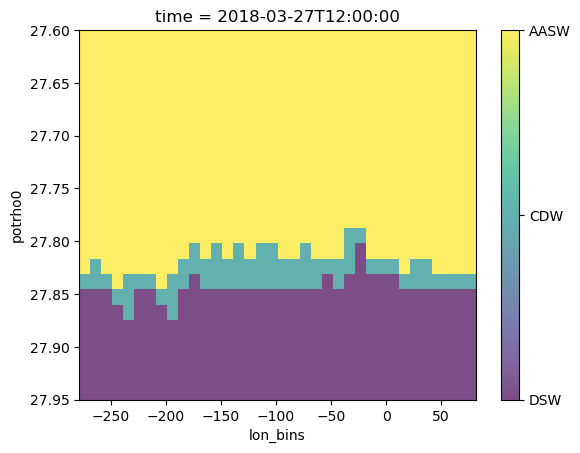

In [30]:
#example of water mass distribution in a specific time
timeind=22000
(CDW_Age_masks_daily.isel(time=timeind)*2).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
DSW_Age_masks_daily.isel(time=timeind).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
AASW_plot = (AASW_Age_masks_daily.isel(time=timeind)*3).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
plt.ylim(27.95,27.6);
cbar = plt.colorbar(AASW_plot)
cbar.ax.set_yticks(ticks=[1,2,3],labels=['DSW','CDW','AASW'])

Plot above was tested across different tmes, and we can see that waters definition never overlap